In [1]:
import argparse
import datetime
import json
import numpy as np
import os
import time
from pathlib import Path
import sys
import random

import matplotlib.pyplot as plt

import torch

import models_mae
import util.misc as misc
from engine_pretrain import train_one_epoch
from main_ViT import main, get_args_parser, run_one_image, DATASET_PATH, SemanticMapDataset
import timm.optim.optim_factory as optim_factory
from util.misc import NativeScalerWithGradNormCount as NativeScaler

In [2]:
world_size = torch.cuda.device_count()
print('world_size = %d' % world_size)
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12355'
os.environ['WORLD_SIZE'] = str(world_size)

torch.multiprocessing.spawn(main, nprocs=world_size, args=(world_size,))

In [3]:
args = get_args_parser()
args = args.parse_args()

args.resume = '/home/placido.falqueto/IRI_Barcelona/mae/output_dir/checkpoint-25.pth'

device = torch.device(args.device)

# define the model
model = models_mae.__dict__[args.model](norm_pix_loss=args.norm_pix_loss)

model.to(device)

model_without_ddp = model

eff_batch_size = args.batch_size * args.accum_iter * misc.get_world_size()

if args.lr is None:  # only base_lr is specified
    args.lr = args.blr * eff_batch_size / 256

# following timm: set wd as 0 for bias and norm layers
param_groups = optim_factory.add_weight_decay(model_without_ddp, args.weight_decay)
optimizer = torch.optim.AdamW(param_groups, lr=args.lr, betas=(0.9, 0.95))
loss_scaler = NativeScaler()

misc.load_model(args=args, model_without_ddp=model_without_ddp, optimizer=optimizer, loss_scaler=loss_scaler)

Resume checkpoint /home/placido.falqueto/IRI_Barcelona/mae/output_dir/checkpoint-25.pth
With optim & sched!


In [4]:
test_data_dirs = ['stanford_hyang3']
print(f'TEST MAP: {test_data_dirs}\n')

dataset_test = SemanticMapDataset(data_dirs=test_data_dirs)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=dataset_test.__len__(), shuffle=False)
features, target = next(iter(data_loader_test))

TEST MAP: ['stanford_hyang3']



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample id: 3618


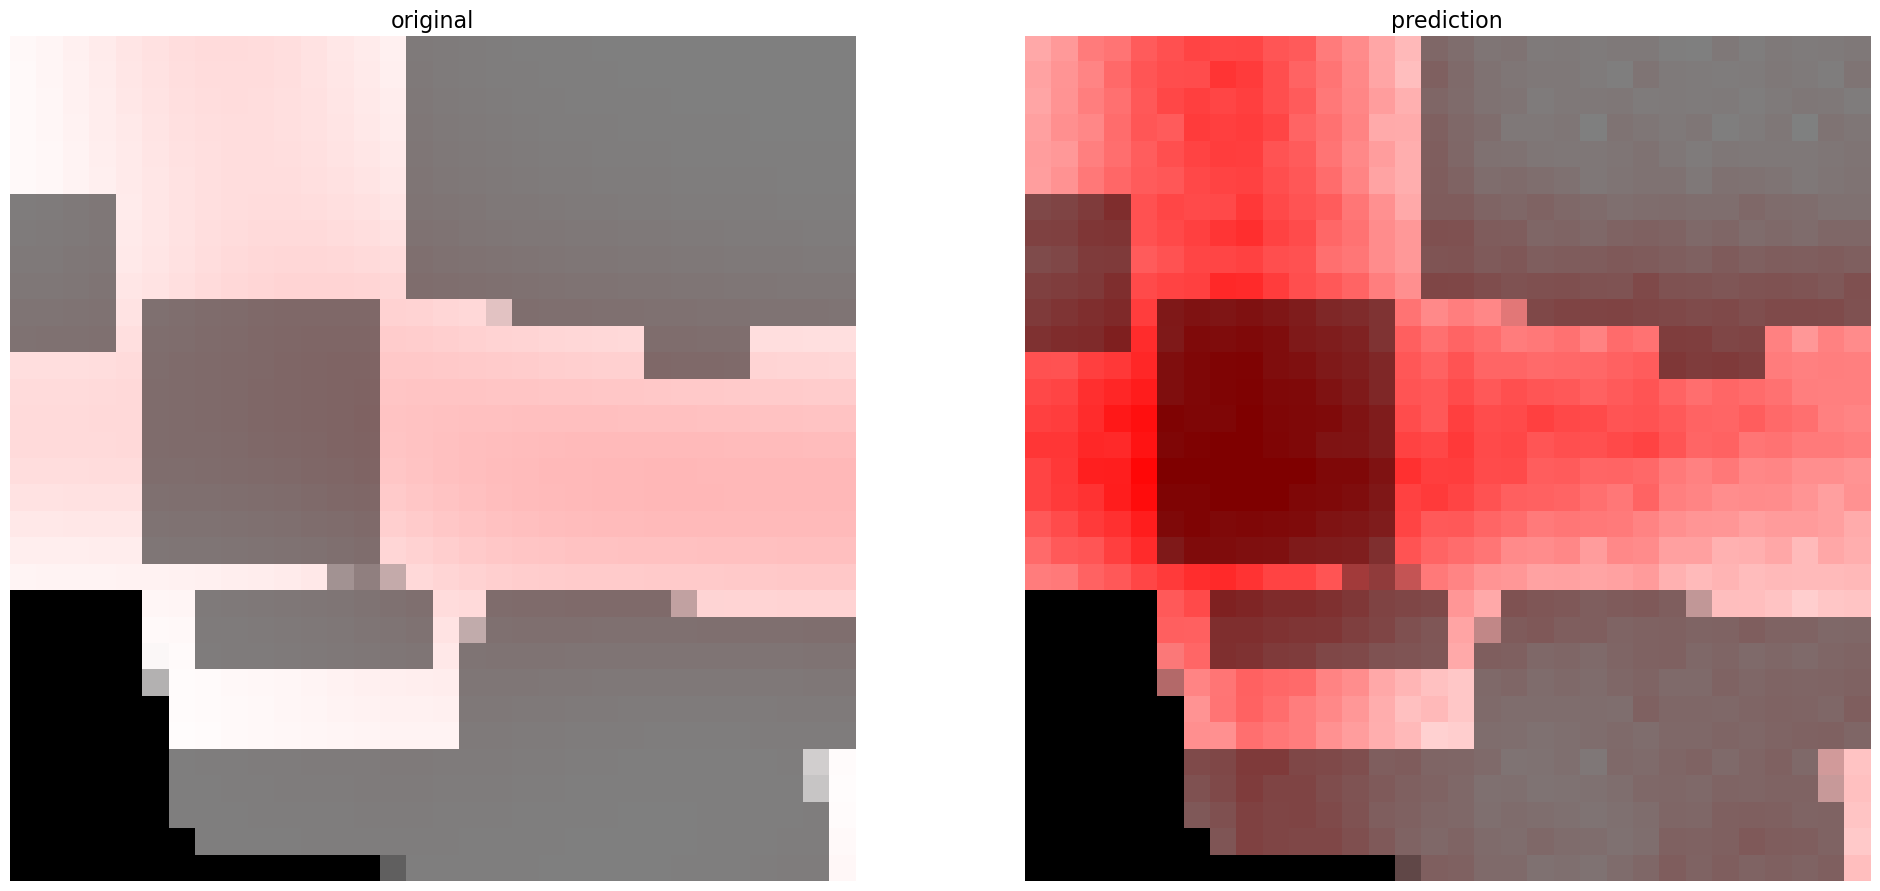

test_loss: 0.1652725338935852
KL divergence 0.025297874584794044
KL divergence 0.03649710863828659


In [6]:
idx = np.random.randint(0, dataset_test.__len__())
print(f'sample id: {idx}')
features_test = features[idx].to('cuda')
target_test = target[idx].to('cuda')
run_one_image(features_test, target_test, model)

features_test = features_test.unsqueeze(dim=0)
target_test = target_test.unsqueeze(dim=0)

# run MAE
test_loss, pred_test, _ = model(features_test, target_test, mask_ratio=args.mask_ratio)
print(f'test_loss: {test_loss}')

N, C, H, W = pred_test.shape
pred_test = pred_test.reshape(N, C*H*W)
pred_test = torch.nn.functional.softmax(pred_test, dim=1)
pred_test = pred_test.reshape(N, C, H, W)

N, H, W = target_test.shape
target_test = target_test.reshape(N, H*W)
target_test = torch.nn.functional.softmax(target_test, dim=1)
target_test = target_test.reshape(N, H, W)

kl = 0
kl = (target_test[0]*(target_test[0].log()-pred_test[0].log())).sum()
print(f'KL divergence {kl.item()}')
kl = 0
kl = (target_test[0]*(target_test[0].log2()-pred_test[0].log2())).sum()
print(f'KL divergence {kl.item()}')
del features_test, target_test, pred_test